In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import r2_score, make_scorer, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [2]:
df = pd.read_csv('preprocessed_residential_apartment.csv')
dff = df.copy()

In [3]:
df.columns

Index(['DESCRIPTION', 'CITY', 'LOCALITY', 'BEDROOM_NUM', 'BATHROOM_NUM',
       'BALCONY_NUM', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'AREA', 'PRICE',
       'TOP_USPS', 'CORNER_PROPERTY', 'FURNISH_LABEL', 'PROP_DETAILS_URL'],
      dtype='object')

In [4]:
input_cols = ['CITY', 'FLOOR_CATEGORY', 'BUILDING_TYPE', 'CORNER_PROPERTY', 'FURNISH_LABEL',
             'BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']

target_cols = ['PRICE']

In [5]:
X = df[input_cols]
y = df[target_cols]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape, X_test.shape

((6264, 9), (1566, 9))

In [8]:
df['FLOOR_CATEGORY'].unique()

array(['High Floors', 'Low Floors', 'Ground Floor'], dtype=object)

In [9]:
preprocessing = ColumnTransformer([
    (
        'ohe_city',
        OneHotEncoder(categories=[['Ahmedabad West', 'Ahmedabad East', 'Gandhinagar','Ahmedabad North', 'Ahmedabad South']]),
        [0]
    ),
    (
        'oe_floor_category',
         OrdinalEncoder(categories=[['Ground Floor', 'Low Floors', 'High Floors']], ),
         [1]
    ),
    (
        'oe_building_type',
         OrdinalEncoder(categories=[['Low-rise buildings', 'Mid-rise buildings', 'High-rise buildings', 'Skyscrapers']]),
         [2]
    ),
    (
        'ohe_corner_property',
        OneHotEncoder(categories=[['N', 'Y']]),
        [3]
    ),
    (
        'ohe_furnish_label',
        OneHotEncoder(categories=[['Unfurnished', 'Semifurnished', 'Furnished']]),
        [4]
    )
], remainder='passthrough')


scaling = ColumnTransformer([
        ('ss', StandardScaler(), list(range(16)))
], remainder='passthrough')

In [10]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', LinearRegression())
])

In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_city',
                                                  OneHotEncoder(categories=[['Ahmedabad '
                                                                             'West',
                                                                             'Ahmedabad '
                                                                             'East',
                                                                             'Gandhinagar',
                                                                             'Ahmedabad '
                                                                             'North',
                                                                             'Ahmedabad '
                                                                             'South']]),
                                                  [0]),
                                                 ('oe_floor_category',
                                                  OrdinalEncoder(categories=[['Ground '
                                                                              'Floor',
                                                                              'Low '
                                                                              'Floors',
                                                                              'High '
                                                                              'Floors']]),
                                                  [1]),
                                                 ('oe_building_type',
                                                  Ordi...
                                                                              'Skyscrapers']]),
                                                  [2]),
                                                 ('ohe_corner_property',
                                                  OneHotEncoder(categories=[['N',
                                                                             'Y']]),
                                                  [3]),
                                                 ('ohe_furnish_label',
                                                  OneHotEncoder(categories=[['Unfurnished',
                                                                             'Semifurnished',
                                                                             'Furnished']]),
                                                  [4])])),
                ('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15])])),
                ('model', LinearRegression())])

In [13]:
def get_error_df(cv_results):
    return pd.DataFrame(cv_results)[list(cv_results.keys())[-4:]].apply(abs)

In [14]:
def get_error_graph(errors_df):
    fig, ax1 = plt.subplots()

    # Plotting RMSE
    color = 'tab:red'
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(errors_df.index, errors_df['test_RMSE'], color=color, label='Test RMSE', marker='o')
    ax1.plot(errors_df.index, errors_df['train_RMSE'], color=color, label='Train RMSE', marker='x', linestyle='--')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='center left')

    # Create a twin Axes sharing the same x-axis for R^2 score
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('R^2 score', color=color)  
    ax2.plot(errors_df.index, errors_df['test_r2'], color=color, label='Test R^2', marker='o')
    ax2.plot(errors_df.index, errors_df['train_r2'], color=color, label='Train R^2', marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='center right')

    # Fine-tune figure; make subplots close to each other and hide x ticks for all but bottom plot.
    fig.tight_layout()  
    plt.title('Model Evaluation Metrics per Fold')
    plt.show()

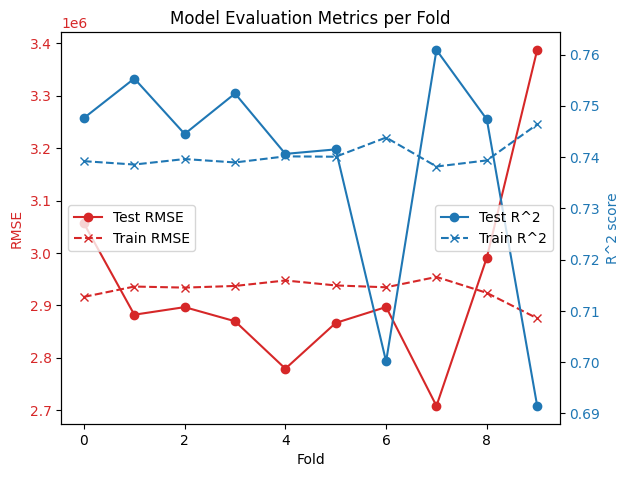

In [15]:
get_error_graph(get_error_df(cv_results))

In [16]:
error_df = get_error_df(cv_results)

In [17]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2929603.1804112275    Train RMSE STD:  21847.138985190406
Test RMSE:  2933355.6031434927    Test RMSE STD:  186492.38370402
Train R2:  0.7404197494216701    Train R2 STD:  0.002610221409924391
Test R2:  0.73817809304559    Test R2 STD:  0.02326715694223446


In [18]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [19]:
def adjusted_r2_score(y_true, y_pred, n_samples, n_features):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1) / (n_samples - n_features - 1))
    return adjusted_r2

In [20]:
print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train MAE: ', mean_absolute_error(y_train, y_train_pred))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

print('Train Adj.R2: ', adjusted_r2_score(y_train, y_train_pred, y_train.shape[0], 16))
print('Test Adj.R2: ', adjusted_r2_score(y_test, y_test_pred, y_train.shape[0], 16))

Train RMSE:  2930009.4320678418
Test RMSE:  2893932.192271124
Train MAE:  2101698.81129399
Test MAE:  2046182.74047655
Train R2:  0.7403664747052674
Test R2:  0.7421433418452789
Train Adj.R2:  0.7397014936896253
Test Adj.R2:  0.7414829117939781


In [21]:
ohe_city_categories = ['Ahmedabad West', 'Ahmedabad East', 'Gandhinagar', 'Ahmedabad North', 'Ahmedabad South']
oe_floor_categories = ['Ground Floor', 'Low Floors', 'High Floors']
oe_building_categories = ['Low-rise buildings', 'Mid-rise buildings', 'High-rise buildings', 'Skyscrapers']
ohe_corner_categories = ['N', 'Y']
ohe_furnish_categories = ['Unfurnished', 'Semifurnished', 'Furnished']

feature_names_after_preprocessing = \
    ['CITY_' + city for city in ohe_city_categories] + \
    ['FLOOR_CATEGORY'] + \
    ['BUILDING_TYPE'] + \
    ['CORNER_PROPERTY_' + corner for corner in ohe_corner_categories] + \
    ['FURNISH_LABEL_' + label for label in ohe_furnish_categories] + \
    ['BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']

coefficients = pipeline.named_steps['model'].coef_[0]

feature_coefficients = {}

for feature, coef in zip(feature_names_after_preprocessing, coefficients):
    feature_coefficients[feature] = [coef]

In [22]:
temp_df = pd.DataFrame(np.array(list(feature_coefficients.values())).reshape(1, -1),columns=list(feature_coefficients.keys())).T.reset_index()
temp_df.rename(columns={'index': 'feature', 0: 'coeff'}, inplace=True)

In [23]:
temp_df.sort_values('coeff', ascending=False)

,feature,coeff
15,AREA,3.460752e+06
13,BATHROOM_NUM,8.371840e+05
6,BUILDING_TYPE,8.205280e+05
12,BEDROOM_NUM,3.859520e+05
14,BALCONY_NUM,-2.409600e+04
5,FLOOR_CATEGORY,-1.843620e+05
4,CITY_Ahmedabad South,-7.684941e+16
2,CITY_Gandhinagar,-2.201728e+17
1,CITY_Ahmedabad East,-3.043338e+17
3,CITY_Ahmedabad North,-3.982095e+17


## Ridge

In [26]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', Ridge())
])

# Define the parameter grid to search
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (alpha)
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Solver for optimization
    'model__fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'model__random_state': [42],  # Random state for reproducibility
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__alpha': 10, 'model__fit_intercept': True, 'model__random_state': 42, 'model__solver': 'saga'}


In [39]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', Ridge(alpha=10, fit_intercept=True, solver='saga', random_state=42))
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

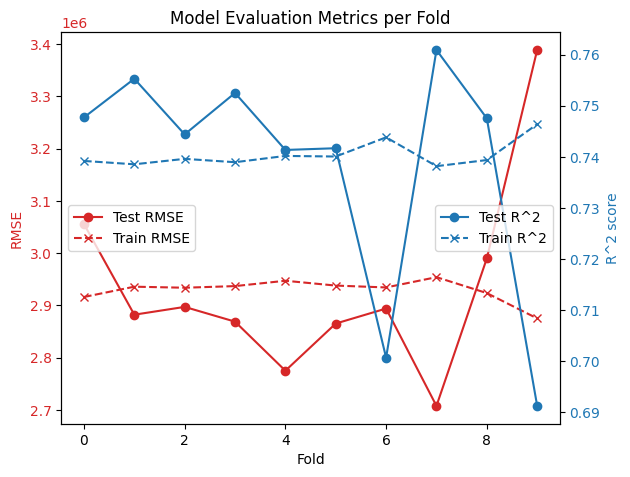

In [40]:
get_error_graph(get_error_df(cv_results))
error_df = get_error_df(cv_results)

In [41]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2929508.964411257    Train RMSE STD:  21832.57140156622
Test RMSE:  2932496.48171144    Test RMSE STD:  187212.3050586883
Train R2:  0.740436425497564    Train R2 STD:  0.002610447013882433
Test R2:  0.738340142069689    Test R2 STD:  0.023241327953636894


In [42]:
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train MAE: ', mean_absolute_error(y_train, y_train_pred))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

print('Train Adj.R2: ', adjusted_r2_score(y_train, y_train_pred, y_train.shape[0], 16))
print('Test Adj.R2: ', adjusted_r2_score(y_test, y_test_pred, y_train.shape[0], 16))

Train RMSE:  2929995.6577677894
Test RMSE:  2893557.0608576513
Train MAE:  2101044.050272297
Test MAE:  2045131.5402280143
Train R2:  0.7403689158316582
Test R2:  0.7422101878228677
Train Adj.R2:  0.7397039410683008
Test Adj.R2:  0.7415499289794494


## Lasso

In [44]:
from sklearn.linear_model import Lasso

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', Lasso())
])

param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (alpha)
    'model__fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'model__random_state': [42],  # Random state for reproducibility
    'model__max_iter': [1000, 2000, 3000],  # Maximum number of iterations for optimization
    'model__tol': [0.0001, 0.001, 0.01],  # Tolerance for stopping criteria
    'model__selection': ['cyclic', 'random'],  # Method to select features when fitting the model
}


# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__alpha': 100, 'model__fit_intercept': True, 'model__max_iter': 1000, 'model__random_state': 42, 'model__selection': 'random', 'model__tol': 0.001}


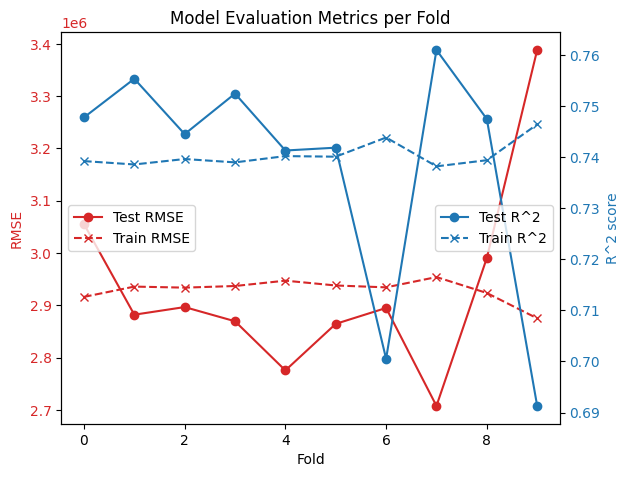

In [105]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', Lasso(alpha=100, fit_intercept=True, max_iter=1000, selection='random',
                    tol=0.001, random_state=42))
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X_train, y_train, n_jobs=-1,
                            scoring={'RMSE': rmse_scorer, 'r2': 'r2'},
                            cv=cv,
                            return_train_score=True)

get_error_graph(get_error_df(cv_results))
error_df = get_error_df(cv_results)

In [106]:
print('Train RMSE: ', error_df.mean().iloc[1], '   Train RMSE STD: ', error_df.std().iloc[1])
print('Test RMSE: ', error_df.mean().iloc[0], '   Test RMSE STD: ', error_df.std().iloc[0])

print('Train R2: ', error_df.mean().iloc[3], '   Train R2 STD: ', error_df.std().iloc[3])
print('Test R2: ', error_df.mean().iloc[2], '   Test R2 STD: ', error_df.std().iloc[2])

Train RMSE:  2929492.6700755963    Train RMSE STD:  21832.659305669127
Test RMSE:  2932526.2639387366    Test RMSE STD:  187169.69798659865
Train R2:  0.7404393126742272    Train R2 STD:  0.0026104751349121293
Test R2:  0.7383324497976109    Test R2 STD:  0.023269451260739257


In [107]:
pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train MAE: ', mean_absolute_error(y_train, y_train_pred))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

print('Train Adj.R2: ', adjusted_r2_score(y_train, y_train_pred, y_train.shape[0], 16))
print('Test Adj.R2: ', adjusted_r2_score(y_test, y_test_pred, y_train.shape[0], 16))

Train RMSE:  2929982.3395462967
Test RMSE:  2893636.7822060008
Train MAE:  2101123.3115192563
Test MAE:  2045050.791363802
Train R2:  0.7403712761194063
Test R2:  0.7421959827222985
Train Adj.R2:  0.7397063074012873
Test Adj.R2:  0.7415356874963591


In [108]:
ohe_city_categories = ['Ahmedabad West', 'Ahmedabad East', 'Gandhinagar', 'Ahmedabad North', 'Ahmedabad South']
oe_floor_categories = ['Ground Floor', 'Low Floors', 'High Floors']
oe_building_categories = ['Low-rise buildings', 'Mid-rise buildings', 'High-rise buildings', 'Skyscrapers']
ohe_corner_categories = ['N', 'Y']
ohe_furnish_categories = ['Unfurnished', 'Semifurnished', 'Furnished']

feature_names_after_preprocessing = \
    ['CITY_' + city for city in ohe_city_categories] + \
    ['FLOOR_CATEGORY'] + \
    ['BUILDING_TYPE'] + \
    ['CORNER_PROPERTY_' + corner for corner in ohe_corner_categories] + \
    ['FURNISH_LABEL_' + label for label in ohe_furnish_categories] + \
    ['BEDROOM_NUM', 'BATHROOM_NUM', 'BALCONY_NUM', 'AREA']

coefficients = pipeline.named_steps['model'].coef_

feature_coefficients = {}

for feature, coef in zip(feature_names_after_preprocessing, coefficients):
    feature_coefficients[feature] = [coef]

temp_df = pd.DataFrame(np.array(list(feature_coefficients.values())).reshape(1, -1),columns=list(feature_coefficients.keys())).T.reset_index()
temp_df.rename(columns={'index': 'feature', 0: 'coeff'}, inplace=True)

temp_df.sort_values('coeff', ascending=False)

,feature,coeff
15,AREA,3.460531e+06
13,BATHROOM_NUM,8.375353e+05
6,BUILDING_TYPE,8.170299e+05
0,CITY_Ahmedabad West,7.198308e+05
11,FURNISH_LABEL_Furnished,6.379498e+05
12,BEDROOM_NUM,3.859545e+05
2,CITY_Gandhinagar,2.776513e+05
10,FURNISH_LABEL_Semifurnished,1.969957e+05
3,CITY_Ahmedabad North,9.526694e+04
4,CITY_Ahmedabad South,4.345425e+04


## Elastic Net

In [120]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', ElasticNet())
])

param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (alpha)
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # L1 ratio, 0 for L2 regularization, 1 for L1 regularization
    'model__fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'model__random_state': [42],  # Random state for reproducibility
    'model__max_iter': [1000, 2000, 3000],  # Maximum number of iterations for optimization
    'model__tol': [0.0001, 0.001, 0.01],  # Tolerance for stopping criteria
    'model__selection': ['cyclic', 'random'],  # Method to select features when fitting the model
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

Best parameters found: 
{'model__alpha': 0.01, 'model__fit_intercept': True, 'model__l1_ratio': 0.9, 'model__max_iter': 1000, 'model__random_state': 42, 'model__selection': 'random', 'model__tol': 0.0001}


C:\Users\baps\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.693e+16, tolerance: 2.071e+13
  model = cd_fast.enet_coordinate_descent(


In [128]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=1000, selection='random',
                    tol=0.0001, fit_intercept=True, random_state=42))
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train MAE: ', mean_absolute_error(y_train, y_train_pred))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

print('Train Adj.R2: ', adjusted_r2_score(y_train, y_train_pred, y_train.shape[0], 16))
print('Test Adj.R2: ', adjusted_r2_score(y_test, y_test_pred, y_train.shape[0], 16))

Train RMSE:  2929987.477682631
Test RMSE:  2893587.939991353
Train MAE:  2101097.9432917116
Test MAE:  2045137.6200719513
Train R2:  0.7403703655276044
Test R2:  0.742204685689414
Train Adj.R2:  0.7397053944772509
Test Adj.R2:  0.7415444127537698


C:\Users\baps\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.693e+16, tolerance: 2.071e+13
  model = cd_fast.enet_coordinate_descent(


In [129]:
from sklearn.svm import SVR

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', SVR())
])

param_grid = {
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'model__gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'model__degree': [2, 3, 4],  # Degree of the polynomial kernel function
    'model__epsilon': [0.1, 0.2, 0.5],  # Epsilon in the epsilon-SVR model
    'model__shrinking': [True, False],  # Whether to use the shrinking heuristic
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

KeyboardInterrupt: 

In [131]:
from sklearn.svm import SVR

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', SVR())
])

param_grid = {
    'model__kernel': ['rbf'],  # Kernel type
    'model__C': [0.1, 1],  # Regularization parameter
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring={'RMSE': rmse_scorer, 'r2': 'r2'}, 
                           refit='RMSE', # Refit using the best RMSE score
                           return_train_score=True,
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Best parameter set
print("Best parameters found: ")
print(grid_search.best_params_)

# Results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

KeyboardInterrupt: 

In [136]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('scaling', scaling),
    ('model', SVR(kernel='linear', C=0.01))
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train RMSE: ', mean_squared_error(y_train, y_train_pred)**0.5)
print('Test RMSE: ', mean_squared_error(y_test, y_test_pred)**0.5)

print('Train MAE: ', mean_absolute_error(y_train, y_train_pred))
print('Test MAE: ', mean_absolute_error(y_test, y_test_pred))

print('Train R2: ', r2_score(y_train, y_train_pred))
print('Test R2: ', r2_score(y_test, y_test_pred))

print('Train Adj.R2: ', adjusted_r2_score(y_train, y_train_pred, y_train.shape[0], 16))
print('Test Adj.R2: ', adjusted_r2_score(y_test, y_test_pred, y_train.shape[0], 16))

C:\Users\baps\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train RMSE:  6052001.823966286
Test RMSE:  5975085.952303796
Train MAE:  4074054.666294131
Test MAE:  3958260.4356875876
Train R2:  -0.10769662859629858
Test R2:  -0.09923351689774074
Train Adj.R2:  -0.11053369375678224
Test Adj.R2:  -0.10204890608781025
